<a href="https://colab.research.google.com/github/KamonohashiPerry/kaggle/blob/master/Titanic_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install kaggle

In [3]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2224           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      16495            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       5403            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        103           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         61           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5362            True  


In [4]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 26.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.73MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 59.5MB/s]


In [0]:
%matplotlib inline

In [0]:
from scipy import stats

In [0]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np

# 学習データ、テストデータの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
pdp.ProfileReport(train)

In [0]:
# import numpy as np
# from sklearn.model_selection import KFold


# def _distance(a, b):
#     return np.linalg.norm(b - a)


# def _get_feat(data, X_train, y_train, class_index, k_index):
#     inclass_X = X_train[y_train == class_index]
#     distances = np.array([_distance(a, data) for a in inclass_X])
#     sorted_distances_index = np.argsort(distances)
#     nearest_index = list(sorted_distances_index[0: (k_index + 1)])
#     dist = np.sum(distances[nearest_index])
#     return dist


# def knnExtract(X, y, k=1, folds=5):
#     CLASS_NUM = len(set(y))
#     res = np.empty((len(X), CLASS_NUM * k))
#     kf = KFold(n_splits=folds,  shuffle=True)

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train = y[train_index]

#         features = np.empty([0, len(X_test)])

#         for class_index in range(CLASS_NUM):
#             for k_index in range(k):
#                 feat = np.array([np.apply_along_axis(
#                     _get_feat, 1,
#                     X_test, X_train, y_train,
#                     class_index, k_index
#                 )])
#                 features = np.append(features, feat, axis=0)
#         res[test_index] = features.T

#     return res

## 前処理

In [9]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## PassengerId

In [0]:
# PassengerIdの階級値に意味があるか
train['PassengerId_bins'] = pd.cut(train['PassengerId'], bins=10, include_lowest=True)

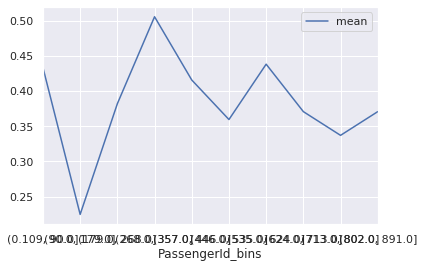

In [168]:
train.groupby('PassengerId_bins')['Survived'].agg([np.mean]).plot();

PassengerIdで生存率に違いがありそうな階級値がある。そこの通し番号に低いクラスが充てがわれたのだろうか？
座席の番号と関係している？  
その前に、クラス間で差があるかどうかの検定を行いたい。

In [169]:
stats.kruskal(*(x[1] for x in train.groupby('PassengerId_bins')['Survived']))

KruskalResult(statistic=18.688955996548138, pvalue=0.02797143230611852)

In [170]:
len(train['PassengerId_bins'].unique())-1

9

有意水準5%で差がある模様。  
ただ、テストデータのIDは連番なので、訓練データの階級値は予測に使えない。    
ただ、乗客IDに何か意味があるのかもしれない。

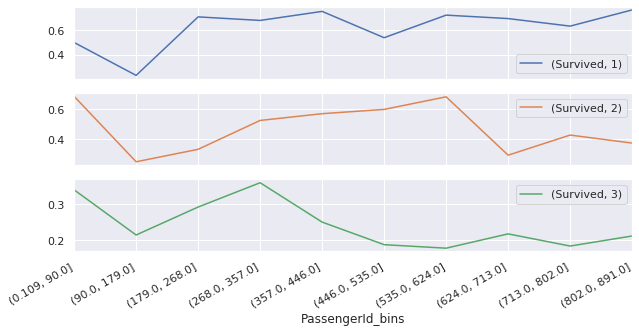

In [171]:
pd.pivot_table(data=train,
               fill_value=0,
               index="PassengerId_bins",
               columns="Pclass",
               aggfunc = {'Survived':np.mean } ).plot(subplots=True, figsize=(10,5));

## Pclass

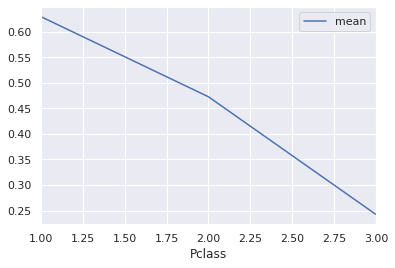

In [172]:
# Pclassに意味はあるか
train.groupby('Pclass')['Survived'].agg([np.mean]).plot();

In [173]:
stats.kruskal(*(x[1] for x in train.groupby('Pclass')['Survived']))

KruskalResult(statistic=102.77351289976991, pvalue=4.819647000539969e-23)

In [0]:
# 意味はあるので特徴量に採用
train['Pclass'] = pd.Categorical(train['Pclass'])
pclass_dummy = pd.get_dummies(train['Pclass'], drop_first=False)

In [175]:
pclass_dummy.head(5)

Pclass,1,2,3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


## Sex

In [176]:
# Sexに意味はあるか
train.groupby('Sex')['Survived'].agg([np.mean, "count"])

,mean,count
Sex,,
female,0.742038,314
male,0.188908,577


In [177]:
stats.kruskal(*(x[1] for x in train.groupby('Sex')['Survived']))

KruskalResult(statistic=262.75534334779314, pvalue=4.304562532204558e-59)

In [0]:
# 意味はあるので特徴量に採用
train['Sex'] = pd.Categorical(train['Sex'])
sex_dummy = pd.get_dummies(train['Sex'], drop_first=False)

In [179]:
sex_dummy.head(5)

Sex,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


## Age

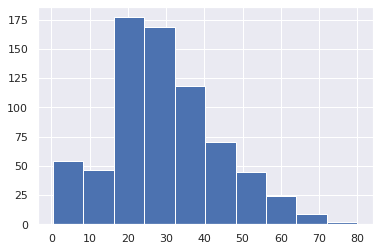

In [180]:
# 年齢に意味はあるか
train['Age'].hist();

In [0]:
# 年齢を5等分してみる。
train['age_bins'] = pd.cut(train['Age'], bins=5, include_lowest=True)

In [0]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

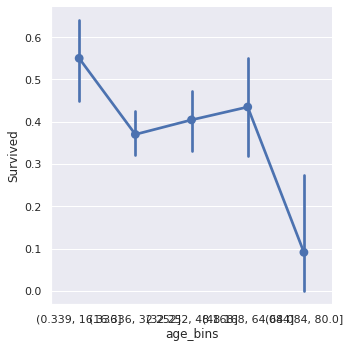

In [183]:
sns.catplot(x="age_bins", y="Survived",kind="point", data=train);

In [184]:
stats.kruskal(*(x[1] for x in train.groupby('age_bins')['Survived']))

KruskalResult(statistic=15.208195093190305, pvalue=0.004288325288499413)

In [0]:
# 意味はあるので特徴量に採用
train['age_bins'] = pd.Categorical(train['age_bins'])
age_bins_dummy = pd.get_dummies(train['age_bins'], drop_first=False)

In [0]:
# 欠損しているものとそうでないものとでの比較
train['age_na_flag'] = np.where(train['Age'].isna(), 1, 0)

In [187]:
# Ageの欠損に意味はあるか
train.groupby('age_na_flag')['Survived'].agg([np.mean, "count"])

,mean,count
age_na_flag,,
0,0.406162,714
1,0.293785,177


In [188]:
stats.kruskal(*(x[1] for x in train.groupby('age_na_flag')['Survived']))

KruskalResult(statistic=7.565177019170002, pvalue=0.005950680941278678)

年齢が欠損している場合、生存の可能性が低い。  
どのようなケースで欠損が発生しているのか。

In [189]:
train.groupby('Pclass')['age_na_flag'].agg([np.mean, "count"])

,mean,count
Pclass,,
1,0.138889,216
2,0.059783,184
3,0.276986,491


In [190]:
stats.kruskal(*(x[1] for x in train.groupby('Pclass')['age_na_flag']))

KruskalResult(statistic=46.010966078690515, pvalue=1.0205767315522344e-10)

どうやら、クラスによって年齢の欠損率に関して差があるらしい。

In [191]:
train.groupby('Sex')['age_na_flag'].agg([np.mean, "count"])

,mean,count
Sex,,
female,0.168790,314
male,0.214905,577


In [192]:
stats.kruskal(*(x[1] for x in train.groupby('Sex')['age_na_flag']))

KruskalResult(statistic=2.7133509866330936, pvalue=0.09951175801285465)

年齢の欠損は男女に関しては差があるとは言えない。

In [193]:
train.groupby('Embarked')['age_na_flag'].agg([np.mean, "count"])

,mean,count
Embarked,,
C,0.226190,168
Q,0.636364,77
S,0.139752,644


In [194]:
stats.kruskal(*(x[1] for x in train.groupby('Embarked')['age_na_flag']))

KruskalResult(statistic=107.20434516645112, pvalue=5.258625330760935e-24)

途中で寄港した際には年齢が欠損しやすいらしい。  
アイルランドなどは特に欠損がひどい。

In [195]:
train.groupby(['Pclass', 'Embarked'])['age_na_flag'].agg([np.mean, "count"])

mean  count
Pclass Embarked                 
1      C         0.129412     85
       Q         0.000000      2
       S         0.149606    127
2      C         0.117647     17
       Q         0.333333      3
       S         0.048780    164
3      C         0.378788     66
       Q         0.666667     72
       S         0.178470    353

アイルランドやフランスで3等席の人が乗ってきて、年齢が欠損しているケースがあるらしい。  
2等席のイギリスでの乗船の場合、年齢の欠損率が低い。律儀な人が多いとかなのだろうか。

ここまででわかっているのは、  
2等席は年齢の欠損が少ない。  
寄港した場合は年齢の欠損が多い。

In [0]:
# 欠損値補完
# 年齢を予測するモデルを作る。運賃で回帰。

In [0]:
import sklearn.linear_model as lm
reg = lm.LinearRegression()

indexer = train['Age'].isnull()
reg.fit(train.loc[~indexer, ['Fare']], train.loc[~indexer, 'Age'])
predicted = reg.predict(train.loc[indexer, ['Fare']])
train.loc[indexer, 'Age'] = predicted

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


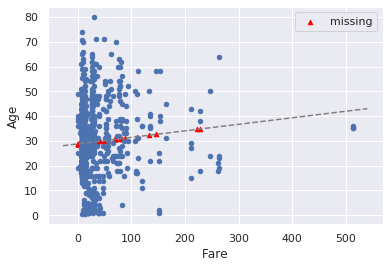

In [423]:
# プロット
ax = train[indexer].plot.scatter(x='Fare', y='Age', marker='^', color='red', label='missing');
ax = train[~indexer].plot.scatter(x='Fare', y='Age', ax=ax);
x = np.linspace(*ax.get_xlim())
ax.plot(x, reg.coef_[0] * x + reg.intercept_, color='gray', linestyle='dashed');

## SibSp

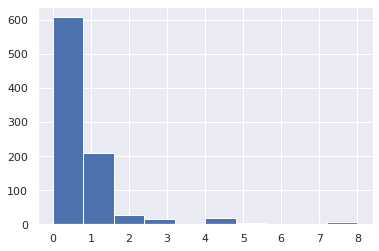

In [196]:
# SibSpに意味はあるか
train['SibSp'].hist();

In [197]:
train.groupby('SibSp')['Survived'].agg([np.mean, "count"])

,mean,count
SibSp,,
0,0.345395,608
1,0.535885,209
2,0.464286,28
3,0.250000,16
4,0.166667,18
5,0.000000,5
8,0.000000,7


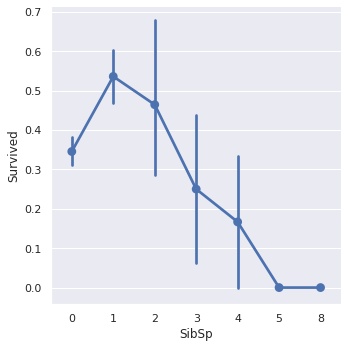

In [198]:
sns.catplot(x="SibSp", y="Survived",kind="point", data=train);

In [199]:
stats.kruskal(*(x[1] for x in train.groupby('SibSp')['Survived']))

KruskalResult(statistic=37.22996149779112, pvalue=1.5881432403790596e-06)

兄弟や配偶者の数が1人はいたほうが生存しやすい。  
多すぎてもよくないかどうかはわからない。

In [0]:
# 意味はあるので特徴量に採用
train['SibSp'] = pd.Categorical(train['SibSp'])
sibsp_dummy = pd.get_dummies(train['SibSp'], drop_first=False)

## Parch

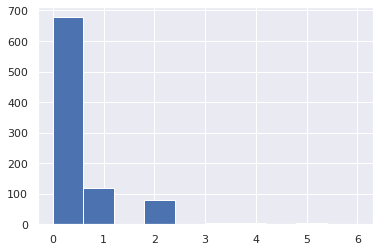

In [201]:
# Parchに意味はあるか
train['Parch'].hist();

In [202]:
train.groupby('Parch')['Survived'].agg([np.mean, "count"])

,mean,count
Parch,,
0,0.343658,678
1,0.550847,118
2,0.500000,80
3,0.600000,5
4,0.000000,4
5,0.200000,5
6,0.000000,1


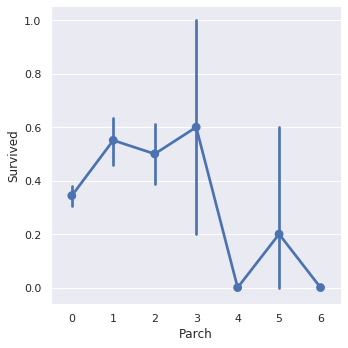

In [203]:
sns.catplot(x="Parch", y="Survived",kind="point", data=train);

In [204]:
stats.kruskal(*(x[1] for x in train.groupby('Parch')['Survived']))

KruskalResult(statistic=27.894441990583733, pvalue=9.836244490848963e-05)

In [0]:
# 意味はあるので特徴量に採用
train['Parch'] = pd.Categorical(train['Parch'])
parch_dummy = pd.get_dummies(train['Parch'], drop_first=False)

## Family Size

In [0]:
train['Familysize'] = train['SibSp'].astype(int) + train['Parch'].astype(int)

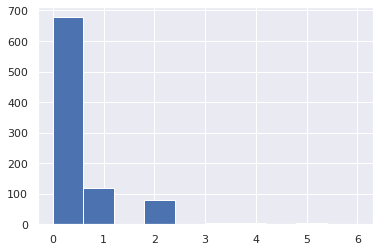

In [427]:
# Familysizeに意味はあるか
train['Parch'].hist();

In [0]:
train['Familysize_class'] = np.where(train['Familysize'] == 0, 'singleton',
                                     np.where(train['Familysize'] >= 2,'middle_family', 'large_family'))

In [429]:
train.groupby('Familysize_class')['Survived'].agg([np.mean, "count"])

,mean,count
Familysize_class,,
large_family,0.552795,161
middle_family,0.466321,193
singleton,0.303538,537


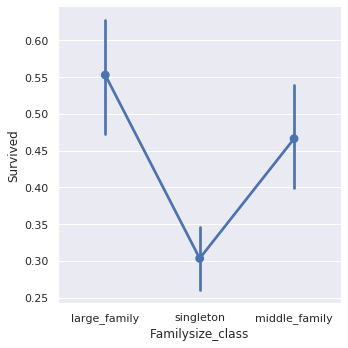

In [430]:
sns.catplot(x="Familysize_class", y="Survived",kind="point", data=train);

In [431]:
stats.kruskal(*(x[1] for x in train.groupby('Familysize_class')['Survived']))

KruskalResult(statistic=39.580931739323276, pvalue=2.5416156647210447e-09)

In [0]:
# 意味はあるので特徴量に採用
train['Familysize_class'] = pd.Categorical(train['Familysize_class'])
familysize_class_dummy = pd.get_dummies(train['Familysize_class'], drop_first=False)

In [353]:
pd.pivot_table(data=train,
               fill_value=0,
               index="Familysize_class",
               columns="Pclass",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2)

Survived                            
                    count            mean            
Pclass                  1    2    3     1     2     3
Familysize_class                                     
large_family           70   34   57  0.73  0.53  0.35
middle_family          37   46  110  0.73  0.72  0.27
singleton             109  104  324  0.53  0.35  0.21

In [354]:
stats.kruskal(*(x[1] for x in train.groupby(['Familysize_class', 'Pclass'])['Survived']))

KruskalResult(statistic=135.1855121795196, pvalue=2.375757130379568e-25)

交互作用項として使えそう。

## Fare

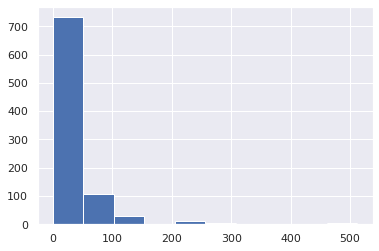

In [206]:
# Fareに意味はあるか
train['Fare'].hist();

In [207]:
train['Fare'].isna().value_counts()

False    891
Name: Fare, dtype: int64

In [208]:
test['Fare'].isna().value_counts()

False    417
True       1
Name: Fare, dtype: int64

無料で乗っている人がいる？

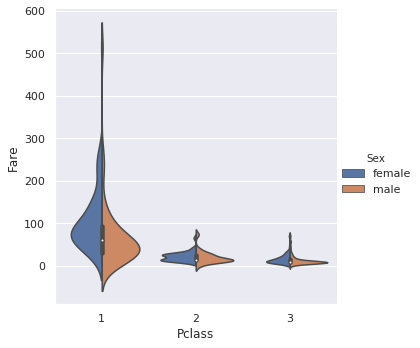

In [209]:
sns.catplot(x="Pclass", y="Fare", hue="Sex",
            kind="violin", split=True, data=train);

1等席は女性の方が高く払っている？

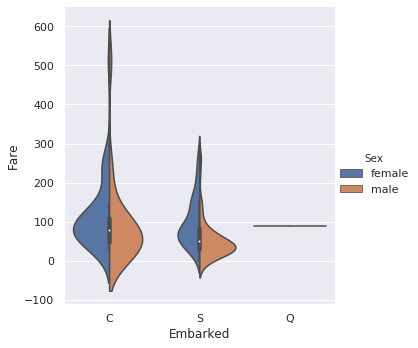

In [210]:
sns.catplot(x="Embarked", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 1 '));

1等席はイギリスから乗った方が安い？

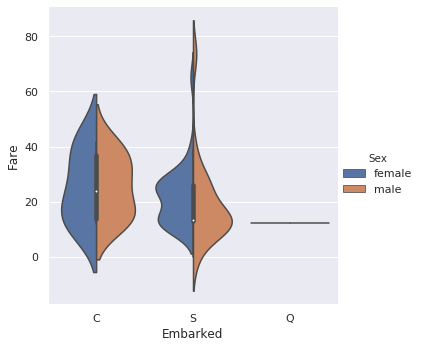

In [211]:
sns.catplot(x="Embarked", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 2 '));

価格に関して多峰性がある？  
年齢なども見てみる？

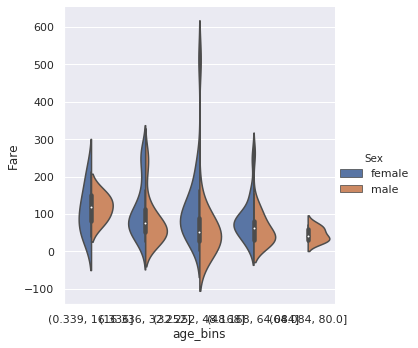

In [212]:
sns.catplot(x="age_bins", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 1 '));

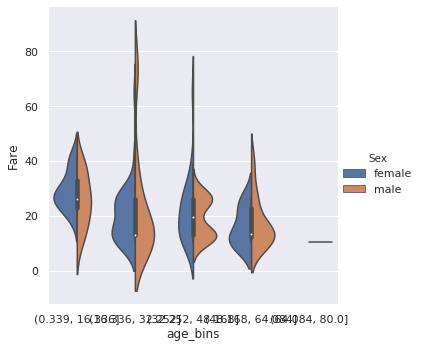

In [213]:
sns.catplot(x="age_bins", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 2 '));

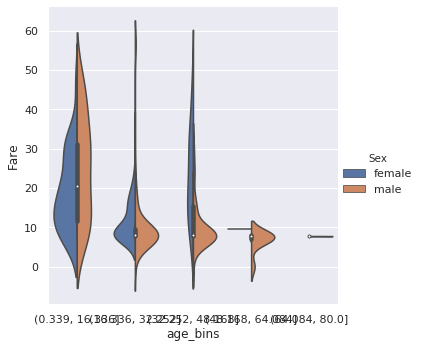

In [214]:
sns.catplot(x="age_bins", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 3 '));

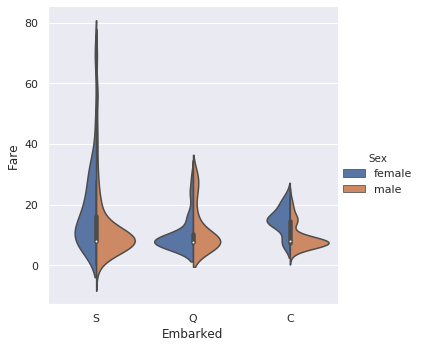

In [215]:
sns.catplot(x="Embarked", y="Fare", hue="Sex",
            kind="violin", split=True, data=train.query(' Pclass == 3 '));

男女で値段が変わることがあるのだろうか？

In [216]:
train.groupby(['Pclass','Sex'])['Fare'].agg([np.mean,np.median])

mean    median
Pclass Sex                         
1      female  106.125798  82.66455
       male     67.226127  41.26250
2      female   21.970121  22.00000
       male     19.741782  13.00000
3      female   16.118810  12.47500
       male     12.661633   7.92500

女性の方が運賃が高いのはなぜだろう。

In [217]:
train.groupby(['Pclass','Sex','age_bins'])['Fare'].agg([np.mean,np.median,'count'])

mean     median  count
Pclass Sex    age_bins                                      
1      female (0.339, 16.336]   111.127783  103.25000    6.0
              (16.336, 32.252]  113.339325   84.82915   32.0
              (32.252, 48.168]  114.038193   84.98750   30.0
              (48.168, 64.084]   85.921324   77.95830   17.0
              (64.084, 80.0]           NaN        NaN    NaN
       male   (0.339, 16.336]   117.802767  120.00000    3.0
              (16.336, 32.252]   81.218515   57.00000   27.0
              (32.252, 48.168]   69.369554   35.50000   39.0
              (48.168, 64.084]   63.846635   43.68125   26.0
              (64.084, 80.0]     45.614600   42.07920    6.0
2      female (0.339, 16.336]    29.240000   27.00000   10.0
              (16.336, 32.252]   20.742478   19.87500   36.0
              (32.252, 48.168]   22.215909   20.25000   22.0
              (48.168, 64.084]   16.083333   13.25000    6.0
              (64.084, 80.0]           NaN        NaN    NaN
       male   (0.339, 16.336]    25.659473   26.00000   11.0
              (16.336, 32.252]   22.507292   13.00000   48.0
              (32.252, 48.168]   19.008178   15.00000   27.0
              (48.168, 64.084]   17.579545   13.50000   11.0
              (64.084, 80.0]     10.500000   10.50000    2.0
3      female (0.339, 16.336]    19.184724   16.70000   33.0
              (16.336, 32.252]   11.662981    9.10000   52.0
              (32.252, 48.168]   23.133075   20.23125   16.0
              (48.168, 64.084]    9.587500    9.58750    1.0
              (64.084, 80.0]           NaN        NaN    NaN
       male   (0.339, 16.336]    25.161151   27.90000   37.0
              (16.336, 32.252]   10.098148    7.89580  151.0
              (32.252, 48.168]   10.104857    7.92500   54.0
              (48.168, 64.084]    6.555213    7.50000    8.0
              (64.084, 80.0]      7.758333    7.75000    3.0

3等室の女性は例外だが、年齢が低いとFareが高くなるのはなぜだろう。  
年齢の欠損値補完に運賃は使えるかもしれない。

In [0]:
# 運賃を4等分してみる。
train['fare_bins'] = pd.cut(train['Fare'], bins=4, include_lowest=True)

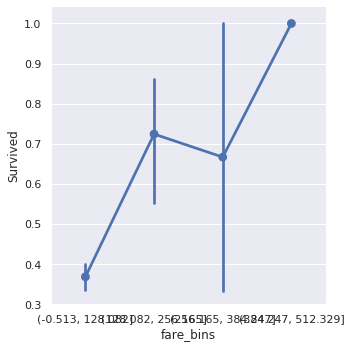

In [219]:
sns.catplot(x="fare_bins", y="Survived",kind="point", data=train);

In [220]:
train.groupby('fare_bins')['Survived'].agg([np.mean, "count"])

,mean,count
fare_bins,,
"(-0.513, 128.082]",0.368113,853
"(128.082, 256.165]",0.724138,29
"(256.165, 384.247]",0.666667,6
"(384.247, 512.329]",1.000000,3


In [221]:
stats.kruskal(*(x[1] for x in train.groupby('fare_bins')['Survived']))

KruskalResult(statistic=21.912092666679513, pvalue=6.803687259731986e-05)

In [0]:
# 意味はあるので特徴量に採用
train['fare_bins'] = pd.Categorical(train['fare_bins'])
fare_bins_dummy = pd.get_dummies(train['fare_bins'], drop_first=False)

## Embarked

In [223]:
# Embarkedに意味はあるか
train.groupby('Embarked')['Survived'].agg([np.mean, "count"])

,mean,count
Embarked,,
C,0.553571,168
Q,0.389610,77
S,0.336957,644


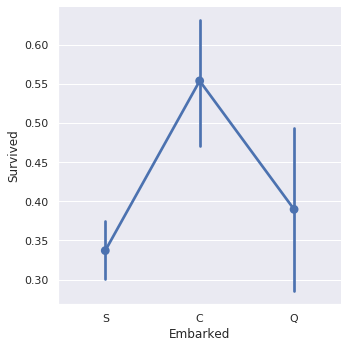

In [224]:
sns.catplot(x="Embarked", y="Survived",kind="point", data=train);

In [225]:
stats.kruskal(*(x[1] for x in train.groupby('Embarked')['Survived']))

KruskalResult(statistic=26.459353270240026, pvalue=1.796488493944477e-06)

In [0]:
# 意味はあるので特徴量に採用
train['Embarked'] = pd.Categorical(train['Embarked'])
embarked_dummy = pd.get_dummies(train['Embarked'], drop_first=False)

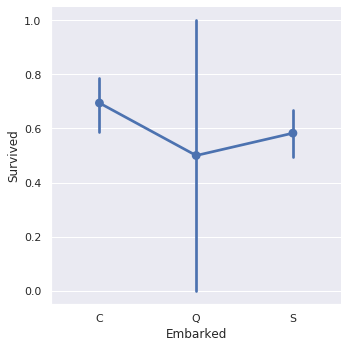

In [227]:
sns.catplot(x="Embarked", y="Survived",kind="point", data=train.query(' Pclass == 1 '));

In [228]:
train.groupby(['Pclass','Embarked'])['Survived'].agg([np.mean, "count"])

mean  count
Pclass Embarked                 
1      C         0.694118     85
       Q         0.500000      2
       S         0.582677    127
2      C         0.529412     17
       Q         0.666667      3
       S         0.463415    164
3      C         0.378788     66
       Q         0.375000     72
       S         0.189802    353

乗客を詰めていくような形式だと、先に乗った人が逃げにくいなどはあるかもしれない。  
確かに、データもそれを支持しているかもしれない。  
座席のデータをうまく作ればわかること。

In [229]:
stats.kruskal(*(x[1] for x in train.groupby(['Pclass','Embarked'])['Survived']))

KruskalResult(statistic=119.12221790883906, pvalue=5.031856540448586e-22)

## Cabin

In [230]:
train['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
E101           3
              ..
E49            1
C106           1
C85            1
A34            1
D47            1
Name: Cabin, Length: 147, dtype: int64

In [231]:
train['Cabin'].isna().value_counts(normalize=True)

True     0.771044
False    0.228956
Name: Cabin, dtype: float64

欠損が77%と非常に多い。

In [0]:
train['Cabin_na_flag'] = np.where(train['Cabin'].isna(), 1, 0)

In [257]:
stats.kruskal(*(x[1] for x in train.groupby('Cabin_na_flag')['Survived']))

KruskalResult(statistic=89.38529299840626, pvalue=3.249432562965501e-21)

In [256]:
train.groupby(['Pclass','Cabin_na_flag'])['Survived'].agg([np.mean, "count"])

mean  count
Pclass Cabin_na_flag                 
1      0              0.664773    176
       1              0.475000     40
2      0              0.812500     16
       1              0.440476    168
3      0              0.500000     12
       1              0.235908    479

In [259]:
stats.kruskal(*(x[1] for x in train.groupby(['Pclass','Cabin_na_flag'])['Survived']))

KruskalResult(statistic=119.71860705830366, pvalue=3.6002510680785595e-24)

同じクラスでも、キャビンの情報が欠損しているかどうかで生存率が異なる。  
交互作用項として採用したい。

In [0]:
def split_element_count(text, expression):
  import re
  import numpy as np
  
  if type(text) is str:
      if bool(re.search(expression,text)):
        return len(text.split(expression))
      else:
        return len([text])

  elif np.isnan(text):
    return text

In [0]:
# スペースの数で座席指定数のようなものを作成
train['Cabin_count'] = list(map(lambda text: split_element_count(text,' '), train['Cabin']))

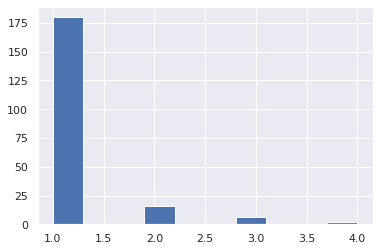

In [234]:
train['Cabin_count'].hist();

そもそも一人が多かったので、座席指定数が多いものも少ない。

In [235]:
# Cabin_countに意味はあるか
train.groupby('Cabin_count')['Survived'].agg([np.mean, "count"])

,mean,count
Cabin_count,,
1.0,0.677778,180
2.0,0.562500,16
3.0,0.500000,6
4.0,1.000000,2


In [236]:
stats.kruskal(*(x[1] for x in train.groupby('Cabin_count')['Survived']))

KruskalResult(statistic=2.6183517156862806, pvalue=0.454281333783783)

In [0]:
def split_and_extract_element(text, element_number, expression):
  import re
  import numpy as np
  
  if type(text) is str:
      if bool(re.search(expression,text)):
        return text.split(expression)[element_number]
      else:
        return text

  elif np.isnan(text):
    return text

In [0]:
train['Cabin_1st_element'] = list(map(lambda text: split_and_extract_element(text, 0, ' '), train['Cabin']))

In [0]:
train['Cabin_1st_element_alphabet'] = train['Cabin_1st_element'].str.replace('[0-9]', '')
train['Cabin_1st_element_number'] = train['Cabin_1st_element'].str.replace('[a-z-A-Z]', '')
train['Cabin_1st_element_number'] = pd.to_numeric(train['Cabin_1st_element_number'], errors='coerce')

In [240]:
train.groupby('Cabin_1st_element_alphabet')['PassengerId'].agg([np.mean, "count"])

,mean,count
Cabin_1st_element_alphabet,,
A,439.600000,15
B,521.808511,47
C,406.440678,59
D,475.939394,33
E,502.437500,32
F,370.384615,13
G,216.000000,4
T,340.000000,1


In [241]:
# Cabin_1st_element_alphabetに意味はあるか
train.groupby('Cabin_1st_element_alphabet')['Survived'].agg([np.mean, "count"])

,mean,count
Cabin_1st_element_alphabet,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1


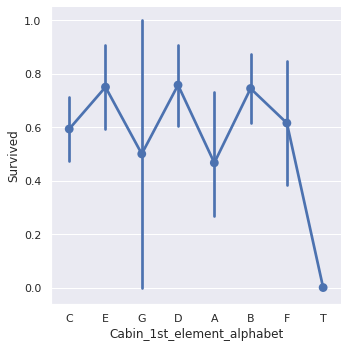

In [242]:
sns.catplot(x="Cabin_1st_element_alphabet", y="Survived",kind="point", data=train);

In [243]:
stats.kruskal(*(x[1] for x in train.groupby('Cabin_1st_element_alphabet')['Survived']))

KruskalResult(statistic=10.250063390397298, pvalue=0.1748399407843878)

有意な差はなさそう。

In [0]:
# 意味はなさそうだが特徴量に採用
train['Cabin_1st_element_alphabet'] = pd.Categorical(train['Cabin_1st_element_alphabet'])
cabin_1st_element_alphabet_dummy = pd.get_dummies(train['Cabin_1st_element_alphabet'], drop_first=False)

In [252]:
cabin_1st_element_alphabet_dummy 

Cabin_1st_element_alphabet,A,B,C,D,E,F,G,T
0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0
887,0,1,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0
889,0,0,1,0,0,0,0,0


In [244]:
pd.pivot_table(data=train,
               fill_value=0,
               index="Cabin_1st_element_alphabet",
               columns="Pclass",
               aggfunc = {'Survived': [np.mean, 'count'] } )#.plot(subplots=True, figsize=(10,5));

Survived                            
                              count            mean            
Pclass                            1  2  3         1      2    3
Cabin_1st_element_alphabet                                     
A                                15  0  0  0.466667  0.000  0.0
B                                47  0  0  0.744681  0.000  0.0
C                                59  0  0  0.593220  0.000  0.0
D                                29  4  0  0.758621  0.750  0.0
E                                25  4  3  0.720000  0.750  1.0
F                                 0  8  5  0.000000  0.875  0.2
G                                 0  0  4  0.000000  0.000  0.5
T                                 1  0  0  0.000000  0.000  0.0

座席番号がまともに存在するのは1等席ばかり。

In [245]:
train.groupby('Cabin_1st_element_alphabet')['Fare'].agg([np.mean, np.median, "count"]).round(2)

,mean,median,count
Cabin_1st_element_alphabet,,,
A,39.62,35.50,15
B,113.51,80.00,47
C,100.15,83.48,59
D,57.24,53.10,33
E,46.03,45.18,32
F,18.70,13.00,13
G,13.58,13.58,4
T,35.50,35.50,1


一番上のAはかえって安かったりするわけですね。  
DとEは比較的安いが、生存率が高い。

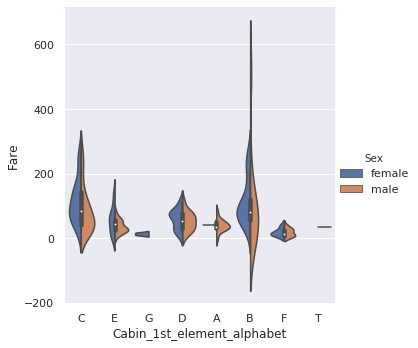

In [246]:
sns.catplot(x="Cabin_1st_element_alphabet", y="Fare", hue="Sex",
            kind="violin", split=True, data=train);

In [0]:
# Cabinの番号を5等分してみる。
train['cabin_1st_element_number_bins'] = pd.cut(train['Cabin_1st_element_number'], bins=5, include_lowest=True)

In [248]:
# cabin_1st_element_number_binsに意味はあるか
train.groupby('cabin_1st_element_number_bins')['Survived'].agg([np.mean, "count"])

,mean,count
cabin_1st_element_number_bins,,
"(1.8530000000000002, 31.2]",0.680556,72
"(31.2, 60.4]",0.724138,58
"(60.4, 89.6]",0.551724,29
"(89.6, 118.8]",0.720000,25
"(118.8, 148.0]",0.666667,12


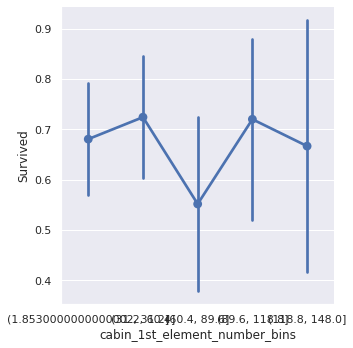

In [249]:
sns.catplot(x="cabin_1st_element_number_bins", y="Survived",kind="point", data=train);

In [151]:
stats.kruskal(*(x[1] for x in train.groupby('cabin_1st_element_number_bins')['Survived']))

KruskalResult(statistic=2.8825099146331894, pvalue=0.577675652036294)

番号だけで差はなさそう

In [0]:
# 意味はなさそうだが特徴量に採用
train['cabin_1st_element_number_bins'] = pd.Categorical(train['cabin_1st_element_number_bins'])
cabin_1st_element_number_bins_dummy = pd.get_dummies(train['cabin_1st_element_number_bins'], drop_first=False)

In [154]:
pd.pivot_table(data=train,
               fill_value=0,
               index="cabin_1st_element_number_bins",
               columns="Cabin_1st_element_alphabet",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2) #.plot(subplots=True, figsize=(10,5));

Survived              ...                       
                                 count              ...  mean                 
Cabin_1st_element_alphabet           A   B   C   D  ...     D     E     F    G
cabin_1st_element_number_bins                       ...                       
(1.8530000000000002, 31.2]          12  14  11  16  ...  0.75  0.90  0.80  0.5
(31.2, 60.4]                         3  16   9  14  ...  0.79  0.67  0.75  0.0
(60.4, 89.6]                         0  10  14   0  ...  0.00  0.40  0.00  0.0
(89.6, 118.8]                        0   7  15   0  ...  0.00  1.00  0.00  0.0
(118.8, 148.0]                       0   0  10   0  ...  0.00  1.00  0.00  0.0

[5 rows x 14 columns]

In [250]:
stats.kruskal(*(x[1] for x in train.groupby(['cabin_1st_element_number_bins','Cabin_1st_element_alphabet'])['Survived']))

KruskalResult(statistic=18.280499227867544, pvalue=0.5689362435720017)

## Ticket

In [260]:
train['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [0]:
# チケットに表記されたスペースの数をカウント
train['Ticket_space_count'] = list(map(lambda text: split_element_count(text, ' '), train['Ticket']))

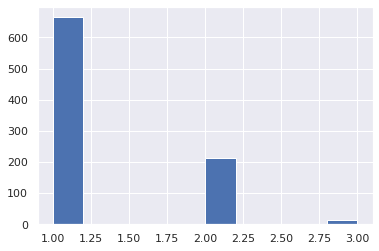

In [434]:
train['Ticket_space_count'].hist();

3パターンぐらいあるらしい。

In [435]:
# Ticket_space_countに意味はあるか
train.groupby('Ticket_space_count')['Survived'].agg([np.mean, "count"])

,mean,count
Ticket_space_count,,
1,0.383459,665
2,0.380282,213
3,0.461538,13


In [436]:
stats.kruskal(*(x[1] for x in train.groupby(['Ticket_space_count'])['Survived']))

KruskalResult(statistic=0.3432636071707115, pvalue=0.8422892439612397)

これは意味がなさそう。

In [0]:
train['Ticket_1st_element'] = list(map(lambda text: split_and_extract_element(text, 0, ' '), train['Ticket']))
train['Ticket_2nd_element'] = list(map(lambda text: split_and_extract_element(text, 1, ' '), train['Ticket']))
train['Ticket_2nd_element'] = train['Ticket_2nd_element'].str.replace('.', '')
train['Ticket_2nd_element'] = np.where(train['Ticket_2nd_element'].isin(['LINE', 'Basle']), 0, train['Ticket_2nd_element'] )
train['Ticket_2nd_element'] = train['Ticket_2nd_element'].astype(int)

In [0]:
# Ticket_2nd_elementの階級値に意味があるか
bins = [0,310000,610000,10000000]
train['ticket_2nd_element_bins'] = pd.cut(train['Ticket_2nd_element'], bins=bins, include_lowest=True)

In [439]:
train.groupby('ticket_2nd_element_bins')['Survived'].agg([np.mean,'count'])

,mean,count
ticket_2nd_element_bins,,
"(-0.001, 310000.0]",0.468121,596
"(310000.0, 610000.0]",0.212928,263
"(610000.0, 10000000.0]",0.218750,32


In [309]:
stats.kruskal(*(x[1] for x in train.groupby(['ticket_2nd_element_bins'])['Survived']))

KruskalResult(statistic=54.01048308941891, pvalue=1.8697029560541314e-12)

In [0]:
# 意味はあるので特徴量に採用
train['ticket_2nd_element_bins'] = pd.Categorical(train['ticket_2nd_element_bins'])
ticket_2nd_element_bins_dummy = pd.get_dummies(train['ticket_2nd_element_bins'], drop_first=False)

In [441]:
train.groupby(['Embarked','ticket_2nd_element_bins'])['Survived'].agg([np.mean,'count'])

mean  count
Embarked ticket_2nd_element_bins                 
C        (-0.001, 310000.0]       0.565217  161.0
         (310000.0, 610000.0]     0.285714    7.0
         (610000.0, 10000000.0]        NaN    NaN
Q        (-0.001, 310000.0]       0.555556   18.0
         (310000.0, 610000.0]     0.338983   59.0
         (610000.0, 10000000.0]        NaN    NaN
S        (-0.001, 310000.0]       0.424096  415.0
         (310000.0, 610000.0]     0.172589  197.0
         (610000.0, 10000000.0]   0.218750   32.0

In [442]:
stats.kruskal(*(x[1] for x in train.groupby(['ticket_2nd_element_bins','Embarked'])['Survived']))

KruskalResult(statistic=69.13944137470698, pvalue=6.138116164304025e-13)

チケットの番号と乗船場所には何か生存率に影響がある模様

In [311]:
pd.pivot_table(data=train,
               fill_value=0,
               index="ticket_2nd_element_bins",
               columns="Pclass",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2) #.plot(subplots=True, figsize=(10,5));

Survived                            
                           count            mean            
Pclass                         1    2    3     1     2     3
ticket_2nd_element_bins                                     
(-0.001, 310000.0]           216  184  196  0.63  0.47  0.29
(310000.0, 610000.0]           0    0  263  0.00  0.00  0.21
(610000.0, 10000000.0]         0    0   32  0.00  0.00  0.22

In [312]:
stats.kruskal(*(x[1] for x in train.groupby(['ticket_2nd_element_bins', 'Pclass'])['Survived']))

KruskalResult(statistic=105.36699220256156, pvalue=7.074392426256396e-22)

後ろの方チケット番号は3等席しかないみたい。  
しかも後ろのほうが前の人よりも生存率が低い。

## Name

In [313]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [0]:
train['Name_space_count'] = list(map(lambda text: split_element_count(text, ' '), train['Name']))

In [0]:
train['Name_space_count'].hist();

In [0]:
train['Name_space_count_class'] = np.where(train['Name_space_count'].astype(int) <= 3, 'under3',
                                     np.where(train['Name_space_count'].astype(int) <= 5,'under5', 'over6'))

In [11]:
train.groupby('Name_space_count_class')['Survived'].agg([np.mean,'count'])

,mean,count
Name_space_count_class,,
over6,0.784314,102
under3,0.291803,305
under5,0.357438,484


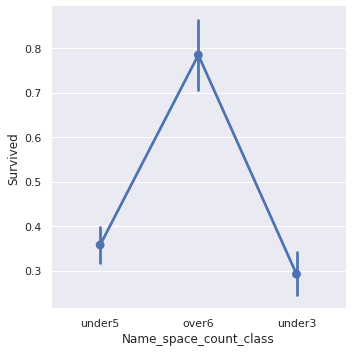

In [16]:
sns.catplot(x="Name_space_count_class", y="Survived",kind="point", data=train);

名前の間にスペースが多いほうが生存率が高そう。

In [368]:
stats.kruskal(*(x[1] for x in train.groupby(['Name_space_count_class'])['Survived']))

KruskalResult(statistic=81.42694996228016, pvalue=2.081433195537374e-18)

In [0]:
# 意味はあるので特徴量に採用
train['Name_space_count_class'] = pd.Categorical(train['Name_space_count_class'])
name_space_count_class_dummy = pd.get_dummies(train['Name_space_count_class'], drop_first=False)

In [18]:
pd.pivot_table(data=train,
               fill_value=0,
               index="Name_space_count_class",
               columns="Pclass",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2)

Survived                            
                          count            mean            
Pclass                        1    2    3     1     2     3
Name_space_count_class                                     
over6                        45   27   30  0.96  0.85  0.47
under3                       44   50  211  0.61  0.46  0.18
under5                      127  107  250  0.52  0.38  0.26

In [22]:
stats.kruskal(*(x[1] for x in train.groupby(['Name_space_count_class', 'Pclass'])['Survived']))

KruskalResult(statistic=159.36115177873592, pvalue=2.1753195203744363e-30)

In [23]:
pd.pivot_table(data=train,
               fill_value=0,
               index="Name_space_count_class",
               columns="Sex",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2)

Survived                  
                          count        mean      
Sex                      female male female  male
Name_space_count_class                           
over6                        90   12   0.82  0.50
under3                       76  229   0.72  0.15
under5                      148  336   0.70  0.21

あらゆるクラスにおいて名前が長いと性別に関係なく生存率が高そう。  
交互作用項にする。

In [0]:
train['Name_1st'] = list(map(lambda text: split_and_extract_element(text, 0, ','), train['Name']))
train['Name_2nd'] = list(map(lambda text: split_and_extract_element(text, 1, ','), train['Name']))
train['Name_honorific'] = list(map(lambda text: split_and_extract_element(text, 0, '.'), train['Name_2nd']))
train['Name_honorific'] = train['Name_honorific'].str.replace(' ', '')

honorific_list = ['Miss', 'Mr', 'Mrs', 'Master']
train['Name_honorific_class'] = np.where(train['Name_honorific'].isin(honorific_list),
                                         train['Name_honorific'], 'otherwise')

In [25]:
train.groupby('Name_honorific_class')['Survived'].agg([np.mean,'count'])

,mean,count
Name_honorific_class,,
Master,0.575000,40
Miss,0.697802,182
Mr,0.156673,517
Mrs,0.792000,125
otherwise,0.444444,27


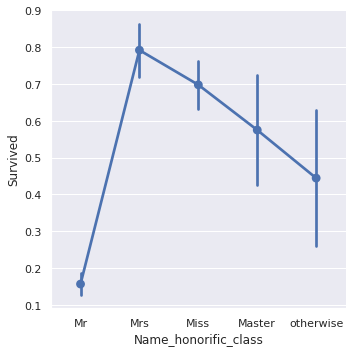

In [26]:
sns.catplot(x="Name_honorific_class", y="Survived",kind="point", data=train);

In [27]:
stats.kruskal(*(x[1] for x in train.groupby(['Name_honorific_class'])['Survived']))

KruskalResult(statistic=282.9935386940024, pvalue=5.04125752981168e-60)

In [0]:
# 意味はあるので特徴量に採用
train['Name_honorific_class'] = pd.Categorical(train['Name_honorific_class'])
name_honorific_class_dummy = pd.get_dummies(train['Name_honorific_class'], drop_first=False)

In [29]:
pd.pivot_table(data=train,
               fill_value=0,
               index="Name_honorific_class",
               columns="Pclass",
               aggfunc = {'Survived': [np.mean, 'count'] } ).round(2)

Survived                           
                        count           mean            
Pclass                      1   2    3     1     2     3
Name_honorific_class                                    
Master                      3   9   28  1.00  1.00  0.39
Miss                       46  34  102  0.96  0.94  0.50
Mr                        107  91  319  0.35  0.09  0.11
Mrs                        42  41   42  0.98  0.90  0.50
otherwise                  18   9    0  0.61  0.11  0.00

In [30]:
stats.kruskal(*(x[1] for x in train.groupby(['Name_honorific_class', 'Pclass'])['Survived']))

KruskalResult(statistic=384.5935900676282, pvalue=3.996913445192356e-74)

交互作用項として採用したい。

In [31]:
train['Name_1st'].value_counts()

Andersson     9
Sage          7
Skoog         6
Carter        6
Johnson       6
             ..
Moraweck      1
Dooley        1
Stoytcheff    1
Nenkoff       1
Sutton        1
Name: Name_1st, Length: 667, dtype: int64

## Target Encoding

In [0]:
# target encodingで名前ごとの生存率を計算する
from sklearn.model_selection import StratifiedKFold

last_name_df = train.groupby('Name_1st').agg({'Survived': ['sum', 'count']})

folds = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=42)

ts = pd.Series(np.empty(train.shape[0]), index=train.index)


for _, holdout_idx in folds.split(train, train['Survived']):
  # ホールドアウトする行を取り出す
  holdout_df = train.iloc[holdout_idx]
  # ホールドアウトしたデータで合計とカウントを計算する
  holdout_last_name_df = holdout_df.groupby('Name_1st').agg({'Survived': ['sum', 'count']})
  # 全体の集計からホールドアウトした分を引く
  train_last_name_df = last_name_df - holdout_last_name_df
  # ホールドアウトしたデータの平均値を計算していく
  oof_ts = holdout_df.apply(lambda row: train_last_name_df.loc[row.Name_1st][('Survived', 'sum')] \
                                        / (train_last_name_df.loc[row.Name_1st][('Survived', 'count')] + 1), axis=1)
  # 生成した特徴量を記録する
  ts[oof_ts.index] = oof_ts


train['holdout_ts'] = ts

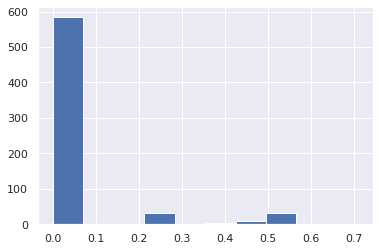

In [33]:
target_encoding_df = train.groupby('Name_1st')['holdout_ts'].agg([np.mean]).reset_index()
target_encoding_df = target_encoding_df.rename(columns = {'mean':'target_score'})
target_encoding_df.target_score.hist();

# 訓練用データとテスト用データの前処理

In [36]:
# 学習データ、テストデータの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset = train.append(test).reset_index(drop=True)


dataset['Pclass'] = pd.Categorical(dataset['Pclass'])
pclass_dummy = pd.get_dummies(dataset['Pclass'], drop_first=False)

dataset['Sex'] = pd.Categorical(dataset['Sex'])
sex_dummy = pd.get_dummies(dataset['Sex'], drop_first=False)

dataset['age_na_flag'] = np.where(dataset['Age'].isna(), 1, 0)

indexer_dataset = dataset['Age'].isnull()
predicted = reg.predict(dataset.loc[indexer_dataset, ['Fare']])
dataset.loc[indexer_dataset, 'Age'] = predicted

dataset['age_bins'] = pd.cut(dataset['Age'], bins=5, include_lowest=True)
dataset['age_bins'] = pd.Categorical(dataset['age_bins'])
age_bins_dummy = pd.get_dummies(dataset['age_bins'], drop_first=False)


dataset['Familysize'] = dataset['SibSp'].astype(int) + dataset['Parch'].astype(int)
dataset['Familysize_class'] = np.where(dataset['Familysize'] == 0, 'singleton',
                                     np.where(dataset['Familysize'] >= 2,'middle_family', 'large_family'))
dataset['Familysize_class'] = pd.Categorical(dataset['Familysize_class'])
familysize_class_dummy = pd.get_dummies(dataset['Familysize_class'], drop_first=False)


dataset['Fare'] = dataset['Fare'].fillna(0)
dataset['fare_bins'] = pd.cut(dataset['Fare'], bins=4, include_lowest=True)
dataset['fare_bins'] = pd.Categorical(dataset['fare_bins'])
fare_bins_dummy = pd.get_dummies(dataset['fare_bins'], drop_first=False)

dataset['Embarked'] = np.where(dataset['Embarked']=='S', 'Southampton',
                               np.where(dataset['Embarked']=='C', 'Cherbourg',
                                        np.where(dataset['Embarked']=='Q', 'Queenstown', None)))

dataset['Embarked'] = pd.Categorical(dataset['Embarked'])
embarked_dummy = pd.get_dummies(dataset['Embarked'], drop_first=False)


dataset['Cabin_na_flag'] = np.where(dataset['Cabin'].isna(), 1, 0)
dataset['Cabin_count'] = list(map(lambda text: split_element_count(text,' '), dataset['Cabin']))
dataset['Cabin_1st_element'] = list(map(lambda text: split_and_extract_element(text, 0, ' '), dataset['Cabin']))
dataset['Cabin_1st_element_alphabet'] = dataset['Cabin_1st_element'].str.replace('[0-9]', '')
dataset['Cabin_1st_element_number'] = dataset['Cabin_1st_element'].str.replace('[a-z-A-Z]', '')
dataset['Cabin_1st_element_number'] = pd.to_numeric(dataset['Cabin_1st_element_number'], errors='coerce')

dataset['Cabin_1st_element_alphabet'] = pd.Categorical(dataset['Cabin_1st_element_alphabet'])
cabin_1st_element_alphabet_dummy = pd.get_dummies(dataset['Cabin_1st_element_alphabet'], drop_first=False)


dataset['cabin_1st_element_number_bins'] = pd.cut(dataset['Cabin_1st_element_number'], bins=5, include_lowest=True)
dataset['cabin_1st_element_number_bins'] = pd.Categorical(dataset['cabin_1st_element_number_bins'])
cabin_1st_element_number_bins_dummy = pd.get_dummies(dataset['cabin_1st_element_number_bins'], drop_first=False)


dataset['Ticket_1st_element'] = list(map(lambda text: split_and_extract_element(text, 0, ' '), dataset['Ticket']))
dataset['Ticket_2nd_element'] = list(map(lambda text: split_and_extract_element(text, 1, ' '), dataset['Ticket']))
dataset['Ticket_2nd_element'] = dataset['Ticket_2nd_element'].str.replace('.', '')
dataset['Ticket_2nd_element'] = np.where(dataset['Ticket_2nd_element'].isin(['LINE', 'Basle']), 0, dataset['Ticket_2nd_element'] )
dataset['Ticket_2nd_element'] = dataset['Ticket_2nd_element'].astype(int)

bins = [0,310000,610000,10000000]
dataset['ticket_2nd_element_bins'] = pd.cut(dataset['Ticket_2nd_element'], bins=bins, include_lowest=True)
dataset['ticket_2nd_element_bins'] = pd.Categorical(dataset['ticket_2nd_element_bins'])
ticket_2nd_element_bins_dummy = pd.get_dummies(dataset['ticket_2nd_element_bins'], drop_first=False)

dataset['Name_space_count'] = list(map(lambda text: split_element_count(text, ' '), dataset['Name']))
dataset['Name_space_count_class'] = np.where(dataset['Name_space_count'].astype(int) <= 3, 'under3',
                                                  np.where(dataset['Name_space_count'].astype(int) <= 5,'under5', 'over6'))

dataset['Name_space_count_class'] = pd.Categorical(dataset['Name_space_count_class'])
name_space_count_class_dummy = pd.get_dummies(dataset['Name_space_count_class'], drop_first=False)


dataset['Name_1st'] = list(map(lambda text: split_and_extract_element(text, 0, ','), dataset['Name']))
dataset['Name_2nd'] = list(map(lambda text: split_and_extract_element(text, 1, ','), dataset['Name']))
dataset['Name_honorific'] = list(map(lambda text: split_and_extract_element(text, 0, '.'), dataset['Name_2nd']))
dataset['Name_honorific'] = dataset['Name_honorific'].str.replace(' ', '')

honorific_list = ['Miss', 'Mr', 'Mrs', 'Master']
dataset['Name_honorific_class'] = np.where(dataset['Name_honorific'].isin(honorific_list),
                                                dataset['Name_honorific'], 'otherwise')

dataset['Name_honorific_class'] = pd.Categorical(dataset['Name_honorific_class'])
name_honorific_class_dummy = pd.get_dummies(dataset['Name_honorific_class'], drop_first=False)

dataset = pd.merge(dataset, target_encoding_df, on='Name_1st', how='left')
dataset['target_score'] = dataset['target_score'].fillna(target_encoding_df.target_score.mean())

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


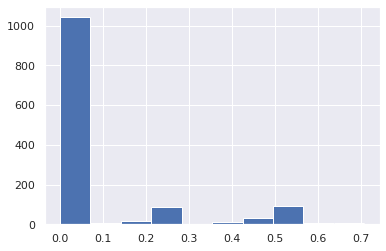

In [37]:
dataset.target_score.hist();

In [38]:
dataset.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,age_na_flag,age_bins,Familysize,Familysize_class,fare_bins,Cabin_na_flag,Cabin_count,Cabin_1st_element,Cabin_1st_element_alphabet,Cabin_1st_element_number,cabin_1st_element_number_bins,Ticket_1st_element,Ticket_2nd_element,ticket_2nd_element_bins,Name_space_count,Name_space_count_class,Name_1st,Name_2nd,Name_honorific,Name_honorific_class,target_score
count,1309.000000,295,1307,1309.000000,1309,1309.000000,1309.000000,1309.0,1309,1309.000000,891.000000,1309,1309.000000,1309,1309.000000,1309,1309,1309.000000,295.000000,295,295,282.000000,282,1309,1.309000e+03,1309,1309.000000,1309,1309,1309,1309,1309,1309.000000
unique,NaN,186,3,NaN,1307,NaN,NaN,3.0,2,NaN,NaN,929,NaN,5,NaN,3,4,NaN,NaN,181,8,NaN,5,755,NaN,3,NaN,3,875,1143,18,5,NaN
top,NaN,C23 C25 C27,Southampton,NaN,"Kelly, Mr. James",NaN,NaN,3.0,male,NaN,NaN,CA. 2343,NaN,"(16.136, 32.102]",NaN,singleton,"(-0.513, 128.082]",NaN,NaN,F,C,NaN,"(1.8530000000000002, 31.2]",PC,NaN,"(-0.001, 310000.0]",NaN,under5,Andersson,Mr. John,Mr,Mr,NaN
freq,NaN,6,914,NaN,2,NaN,NaN,709.0,843,NaN,NaN,11,NaN,783,NaN,790,1242,NaN,NaN,8,94,NaN,102,92,NaN,883,NaN,700,11,13,757,757,NaN
mean,29.765774,NaN,NaN,33.270043,NaN,0.385027,655.000000,NaN,NaN,0.498854,0.383838,NaN,0.200917,NaN,0.883881,NaN,NaN,0.774637,1.206780,NaN,NaN,49.273050,NaN,NaN,2.498722e+05,NaN,4.089381,NaN,NaN,NaN,NaN,NaN,0.086720
std,12.889351,NaN,NaN,51.747063,NaN,0.865560,378.020061,NaN,NaN,1.041658,0.486592,NaN,0.400839,NaN,1.583639,NaN,NaN,0.417981,0.578487,NaN,NaN,34.339936,NaN,NaN,5.643465e+05,NaN,1.184295,NaN,NaN,NaN,NaN,NaN,0.164621
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,1.000000,NaN,NaN,2.000000,NaN,NaN,0.000000e+00,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,22.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,23.000000,NaN,NaN,1.350700e+04,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,28.992415,NaN,NaN,14.454200,NaN,0.000000,655.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,40.500000,NaN,NaN,6.530400e+04,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,35.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,NaN,NaN,1.000000,1.000000,NaN,0.000000,NaN,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,76.000000,NaN,NaN,3.470620e+05,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,0.047794


In [39]:
dataset.tail(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,age_na_flag,age_bins,Familysize,Familysize_class,fare_bins,Cabin_na_flag,Cabin_count,Cabin_1st_element,Cabin_1st_element_alphabet,Cabin_1st_element_number,cabin_1st_element_number_bins,Ticket_1st_element,Ticket_2nd_element,ticket_2nd_element_bins,Name_space_count,Name_space_count_class,Name_1st,Name_2nd,Name_honorific,Name_honorific_class,target_score
1304,28.996481,NaN,Southampton,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,1,"(16.136, 32.102]",0,singleton,"(-0.513, 128.082]",1,NaN,NaN,NaN,NaN,NaN,A.5.,3236,"(-0.001, 310000.0]",3,under3,Spector,Mr. Woolf,Mr,Mr,0.047794
1305,39.000000,C105,Cherbourg,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,0,"(32.102, 48.068]",0,singleton,"(-0.513, 128.082]",0,1.0,C105,C,105.0,"(89.6, 118.8]",PC,17758,"(-0.001, 310000.0]",5,under5,Oliva y Ocana,Dona. Fermina,Dona,otherwise,0.047794
1306,38.500000,NaN,Southampton,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,0,"(32.102, 48.068]",0,singleton,"(-0.513, 128.082]",1,NaN,NaN,NaN,NaN,NaN,SOTON/O.Q.,3101262,"(610000.0, 10000000.0]",4,under5,Saether,Mr. Simon Sivertsen,Mr,Mr,0.047794
1307,28.996481,NaN,Southampton,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,1,"(16.136, 32.102]",0,singleton,"(-0.513, 128.082]",1,NaN,NaN,NaN,NaN,NaN,359309,359309,"(310000.0, 610000.0]",3,under3,Ware,Mr. Frederick,Mr,Mr,0.047794
1308,29.373802,NaN,Cherbourg,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,1,"(16.136, 32.102]",2,middle_family,"(-0.513, 128.082]",1,NaN,NaN,NaN,NaN,NaN,2668,2668,"(-0.001, 310000.0]",4,under5,Peter,Master. Michael J,Master,Master,0.500000


In [0]:
cross_singleton_plcass_1 = familysize_class_dummy["singleton"] * pclass_dummy[1]
cross_singleton_plcass_2 = familysize_class_dummy["singleton"] * pclass_dummy[2]
cross_singleton_plcass_3 = familysize_class_dummy["singleton"] * pclass_dummy[3]

cross_Southampton_plcass_1 = embarked_dummy["Southampton"] * pclass_dummy[1]
cross_Southampton_plcass_2 = embarked_dummy["Southampton"] * pclass_dummy[2]
cross_Southampton_plcass_3 = embarked_dummy["Southampton"] * pclass_dummy[3]

cross_Queenstown_plcass_1 = embarked_dummy["Queenstown"] * pclass_dummy[1]
cross_Queenstown_plcass_2 = embarked_dummy["Queenstown"] * pclass_dummy[2]
cross_Queenstown_plcass_3 = embarked_dummy["Queenstown"] * pclass_dummy[3]

cross_Southampton_ticket_number_1 = embarked_dummy["Southampton"] * ticket_2nd_element_bins_dummy.iloc[:,0]
cross_Southampton_ticket_number_2 = embarked_dummy["Southampton"] * ticket_2nd_element_bins_dummy.iloc[:,1]
cross_Southampton_ticket_number_3 = embarked_dummy["Southampton"] * ticket_2nd_element_bins_dummy.iloc[:,2]

cross_Queenstown_ticket_number_1 = embarked_dummy["Queenstown"] * ticket_2nd_element_bins_dummy.iloc[:,0]
cross_Queenstown_ticket_number_2 = embarked_dummy["Queenstown"] * ticket_2nd_element_bins_dummy.iloc[:,1]
cross_Queenstown_ticket_number_3 = embarked_dummy["Queenstown"] * ticket_2nd_element_bins_dummy.iloc[:,2]

cross_pclass_1_ticket_number_1 = pclass_dummy[1] * ticket_2nd_element_bins_dummy.iloc[:,0]
cross_pclass_1_ticket_number_2 = pclass_dummy[1] * ticket_2nd_element_bins_dummy.iloc[:,1]
cross_pclass_1_ticket_number_3 = pclass_dummy[1] * ticket_2nd_element_bins_dummy.iloc[:,2]

cross_pclass_2_ticket_number_1 = pclass_dummy[2] * ticket_2nd_element_bins_dummy.iloc[:,0]
cross_pclass_2_ticket_number_2 = pclass_dummy[2] * ticket_2nd_element_bins_dummy.iloc[:,1]
cross_pclass_2_ticket_number_3 = pclass_dummy[2] * ticket_2nd_element_bins_dummy.iloc[:,2]

cross_pclass_3_ticket_number_1 = pclass_dummy[3] * ticket_2nd_element_bins_dummy.iloc[:,0]
cross_pclass_3_ticket_number_2 = pclass_dummy[3] * ticket_2nd_element_bins_dummy.iloc[:,1]
cross_pclass_3_ticket_number_3 = pclass_dummy[3] * ticket_2nd_element_bins_dummy.iloc[:,2]


cross_pclass_1_name_space_1 = pclass_dummy[1] * name_space_count_class_dummy["under3"]
cross_pclass_1_name_space_2 = pclass_dummy[1] * name_space_count_class_dummy["under5"]
cross_pclass_1_name_space_3 = pclass_dummy[1] * name_space_count_class_dummy["over6"]

cross_pclass_2_name_space_1 = pclass_dummy[2] * name_space_count_class_dummy["under3"]
cross_pclass_2_name_space_2 = pclass_dummy[2] * name_space_count_class_dummy["under5"]
cross_pclass_2_name_space_3 = pclass_dummy[2] * name_space_count_class_dummy["over6"]

cross_pclass_3_name_space_1 = pclass_dummy[3] * name_space_count_class_dummy["under3"]
cross_pclass_3_name_space_2 = pclass_dummy[3] * name_space_count_class_dummy["under5"]
cross_pclass_3_name_space_3 = pclass_dummy[3] * name_space_count_class_dummy["over6"]

cross_pclass_1_Mr = pclass_dummy[1] * name_honorific_class_dummy["Mr"]
cross_pclass_1_Mrs = pclass_dummy[1] * name_honorific_class_dummy["Mrs"]
cross_pclass_1_Miss = pclass_dummy[1] * name_honorific_class_dummy["Miss"]
cross_pclass_1_Master = pclass_dummy[1] * name_honorific_class_dummy["Master"]

cross_pclass_2_Mr = pclass_dummy[2] * name_honorific_class_dummy["Mr"]
cross_pclass_2_Mrs = pclass_dummy[2] * name_honorific_class_dummy["Mrs"]
cross_pclass_2_Miss = pclass_dummy[2] * name_honorific_class_dummy["Miss"]
cross_pclass_2_Master = pclass_dummy[2] * name_honorific_class_dummy["Master"]

cross_pclass_3_Mr = pclass_dummy[3] * name_honorific_class_dummy["Mr"]
cross_pclass_3_Mrs = pclass_dummy[3] * name_honorific_class_dummy["Mrs"]
cross_pclass_3_Miss = pclass_dummy[3] * name_honorific_class_dummy["Miss"]
cross_pclass_3_Master = pclass_dummy[3] * name_honorific_class_dummy["Master"]

In [205]:
# dataset_ml = dataset[['PassengerId','target_score']]
# dataset_ml = dataset[['PassengerId', 'age_na_flag']]
dataset_ml = dataset[['PassengerId','target_score', 'age_na_flag']]


dataset_ml = pd.concat([dataset_ml,
                          pclass_dummy.drop([2],axis=1),
                          sex_dummy.drop(['male'],axis=1),
                          age_bins_dummy.iloc[:, :-1],
                          familysize_class_dummy.drop(["middle_family"],axis=1),
                          fare_bins_dummy.iloc[:, :-1],
                          embarked_dummy.drop(["Queenstown"],axis=1),
                          cabin_1st_element_alphabet_dummy.drop(["T"],axis=1),
                          cabin_1st_element_number_bins_dummy.iloc[:, :-1],
                          ticket_2nd_element_bins_dummy.iloc[:, :-1],
                          name_space_count_class_dummy.drop(['under5'], axis=1),
                          name_honorific_class_dummy.drop(['otherwise'], axis=1),
                          # 交互作用項の追加
                          cross_singleton_plcass_1,
                          cross_singleton_plcass_2,
                          # cross_Southampton_plcass_1,
                          # cross_Southampton_plcass_2,
                          # cross_Southampton_plcass_3,
                          cross_Queenstown_plcass_1,
                          cross_Queenstown_plcass_2,
                          cross_Queenstown_plcass_3,
                          cross_Southampton_ticket_number_1,
                          cross_Southampton_ticket_number_2,
                          cross_Southampton_ticket_number_3,
                          # cross_Queenstown_ticket_number_1,
                          # cross_Queenstown_ticket_number_2,
                          # cross_Queenstown_ticket_number_3,
                          # cross_pclass_1_ticket_number_1,
                          # cross_pclass_1_ticket_number_2,
                          # cross_pclass_1_ticket_number_3,
                          cross_pclass_2_ticket_number_1,
                          cross_pclass_2_ticket_number_2,
                          cross_pclass_2_ticket_number_3,
                          # cross_pclass_3_ticket_number_1,
                          # cross_pclass_3_ticket_number_2,
                          # cross_pclass_3_ticket_number_3,
                          # cross_pclass_1_name_space_1,
                          # cross_pclass_1_name_space_2,
                          # cross_pclass_1_name_space_3,
                          # cross_pclass_2_name_space_1,
                          # cross_pclass_2_name_space_2,
                          # cross_pclass_2_name_space_3,
                          cross_pclass_3_name_space_1,
                          cross_pclass_3_name_space_2,
                          cross_pclass_3_name_space_3,
                          cross_pclass_1_Mr,
                          cross_pclass_1_Mrs,
                          cross_pclass_1_Miss,
                          cross_pclass_1_Master,
                          cross_pclass_2_Mr,
                          cross_pclass_2_Mrs,
                          cross_pclass_2_Miss,
                          cross_pclass_2_Master
                          # cross_pclass_3_Mr,
                          # cross_pclass_3_Mrs,
                          # cross_pclass_3_Miss,
                          # cross_pclass_3_Master
                        ], axis=1)
print(dataset_ml.shape)
dataset_ml.head(3)

(1309, 58)


,PassengerId,target_score,age_na_flag,1,3,female,"(0.0892, 16.136]","(16.136, 32.102]","(32.102, 48.068]","(48.068, 64.034]",large_family,singleton,"(-0.513, 128.082]","(128.082, 256.165]","(256.165, 384.247]",Cherbourg,Southampton,A,B,C,D,E,F,G,"(1.8530000000000002, 31.2]","(31.2, 60.4]","(60.4, 89.6]","(89.6, 118.8]","(-0.001, 310000.0]","(310000.0, 610000.0]",over6,under3,Master,Miss,Mr,Mrs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,0.0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,0.0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [206]:
dataset_ml_train_label = dataset[dataset.PassengerId <= 891]['Survived']
dataset_ml_train_label = dataset_ml_train_label.values

dataset_ml_train = dataset_ml[dataset_ml.PassengerId <= 891]
dataset_ml_test = dataset_ml[dataset_ml.PassengerId > 891]

dataset_ml_train = dataset_ml_train.drop(['PassengerId'], axis=1)
dataset_ml_test = dataset_ml_test.drop(['PassengerId'], axis=1)

dataset_ml_train = dataset_ml_train.values
dataset_ml_test = dataset_ml_test.values

print(dataset_ml_train.shape)
print(dataset_ml_test.shape)

(891, 57)
(418, 57)


In [0]:
# fare_bins_dummy.iloc[:, :-1]
# embarked_dummy.drop(["Q"],axis=1)
# name_honorific_class_dummy.drop(['otherwise'], axis=1)

In [0]:
# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd /content/LightGBM/
# !mkdir build
# !cmake -DUSE_GPU=1 #avoid ..
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd /content/LightGBM/python-package
# !sudo python setup.py install --precompile

In [0]:
# import lightgbm as lgb

In [483]:
# print(lgb.__version__)

2.3.2


In [0]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

def classification_and_roc_analysis(k, classifier, X, y):
    import numpy as np
    from scipy import interp
    # import matplotlib.pyplot as plt
    
    # from pylab import rcParams
    # rcParams['figure.figsize'] = 8,8

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_curve, auc
    
    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=k,random_state=123)
    classifier = classifier

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        # plt.plot(fpr, tpr, lw=1, alpha=0.3,
        #          label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    # plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    #          label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    # plt.plot(mean_fpr, mean_tpr, color='b',
    #          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    #          lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                  label=r'$\pm$ 1 std. dev.')

    # plt.xlim([-0.05, 1.05])
    # plt.ylim([-0.05, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic example')
    # plt.legend(loc="lower right")
    # plt.show()

    return mean_auc

In [211]:
# 等間隔で実数の数列を作る
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

import random

learning_rate = list(map(lambda value:round(value,2) , frange(0.1, 0.3, 0.01)))
n_estimators = list(map(lambda value:round(value,2) , frange(1, 2000, 100)))
max_depth = list(map(lambda value:round(value,2) , frange(1, 21, 1)))
min_child_weight = list(map(lambda value:round(value,2) , frange(1, 21, 1)))
gamma = list(map(lambda value:round(value,2) , frange(0.1, 0.3, 0.01)))
subsample = list(map(lambda value:round(value,2) , frange(0.1, 1.0, 0.1)))
scale_pos_weight = list(map(lambda value:round(value,2) , frange(0.1, 1.0, 0.1)))

random.choice(learning_rate)

0.13

In [0]:
# パラメータに関するデータフレーム
parameter_df = pd.DataFrame(index=range(1000))

parameter_df['learning_rate'] = list(map(lambda parameter:random.choice(learning_rate) , range(parameter_df.index.size)))
parameter_df['n_estimators'] = list(map(lambda parameter:random.choice(n_estimators) , range(parameter_df.index.size)))
parameter_df['max_depth'] = list(map(lambda parameter:random.choice(max_depth) , range(parameter_df.index.size)))
parameter_df['min_child_weight'] = list(map(lambda parameter:random.choice(min_child_weight) , range(parameter_df.index.size)))
parameter_df['gamma'] = list(map(lambda parameter:random.choice(gamma) , range(parameter_df.index.size)))
parameter_df['subsample'] = list(map(lambda parameter:random.choice(subsample) , range(parameter_df.index.size)))
parameter_df['scale_pos_weight'] = list(map(lambda parameter:random.choice(scale_pos_weight) , range(parameter_df.index.size)))
parameter_df['mean_auc'] = np.nan

In [213]:
parameter_df.head(3)

,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,scale_pos_weight,mean_auc
0,0.21,1801,16,18,0.16,0.7,0.4,NaN
1,0.10,701,19,15,0.24,0.1,0.2,NaN
2,0.25,301,1,18,0.19,0.9,1.0,NaN


In [0]:
import tqdm

import warnings
warnings.filterwarnings('ignore')

In [0]:
# 訓練データとテストデータを分ける
data_train_s, data_test_s, label_train_s, label_test_s = train_test_split(dataset_ml_train, dataset_ml_train_label,
                                                                          train_size=0.8, 
                                                                          test_size=0.2, 
                                                                          random_state=123)

# 正規化を行う
# sc = StandardScaler(with_mean=False)
# sc.fit(data_train_s.astype("float"))
# data_train_s_std = sc.transform(data_train_s.astype("float"))
# data_test_s_std = sc.transform(data_test_s.astype("float"))


# classifier = XGBClassifier(
#                         learning_rate =0.05	, # 0.05
#                         n_estimators=139, # 139
#                         max_depth=5, #5
#                         min_child_weight=5, #5
#                         gamma=0.18, # 0.1
#                         subsample=0.8, # 0.7
#                         colsample_bytree=0.9 , # 0.9
#                         objective= 'binary:logistic',
#                         nthread=4,
#                         scale_pos_weight=1.0, # 0.5
#                         seed=27
#                         )
# classification_and_roc_analysis(k=10, classifier=classifier, X=data_train_s, y= label_train_s)


for i in range(parameter_df.index.size):
  classifier = XGBClassifier(
                          learning_rate=parameter_df.learning_rate[i],
                          n_estimators=parameter_df.n_estimators[i],
                          max_depth=parameter_df.max_depth[i],
                          min_child_weight=parameter_df.min_child_weight[i],
                          gamma=parameter_df.gamma[i],
                          subsample=parameter_df.subsample[i],
                          colsample_bytree=0.9,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=parameter_df.scale_pos_weight[i],
                          seed=27
                          )

  # classification and draw roc curve
  parameter_df['mean_auc'][i] = classification_and_roc_analysis(k=10, classifier=classifier, X=data_train_s, y= label_train_s)
  print(i,":", parameter_df['mean_auc'][i],":",parameter_df.mean_auc.max())

0 : 0.8302077789494949 : 0.8302077789494949
1 : 0.5 : 0.8302077789494949
2 : 0.8567704011774344 : 0.8567704011774344
3 : 0.5735047596167344 : 0.8567704011774344
4 : 0.8796077164857561 : 0.8796077164857561
5 : 0.5 : 0.8796077164857561
6 : 0.8235734619571691 : 0.8796077164857561
7 : 0.8632982016736226 : 0.8796077164857561
8 : 0.8841513513090393 : 0.8841513513090393
9 : 0.5 : 0.8841513513090393
10 : 0.8860891259881157 : 0.8860891259881157
11 : 0.8358043289013041 : 0.8860891259881157
12 : 0.8674455648894481 : 0.8860891259881157
13 : 0.5 : 0.8860891259881157
14 : 0.8336112132784544 : 0.8860891259881157
15 : 0.8603698296272183 : 0.8860891259881157
16 : 0.833821719900497 : 0.8860891259881157
17 : 0.8575831273380845 : 0.8860891259881157
18 : 0.886113634879067 : 0.886113634879067
19 : 0.8815262502458536 : 0.886113634879067
20 : 0.867238095418043 : 0.886113634879067
21 : 0.5 : 0.886113634879067
22 : 0.8726503832798258 : 0.886113634879067
23 : 0.5 : 0.886113634879067
24 : 0.8340089027483893 : 0.8

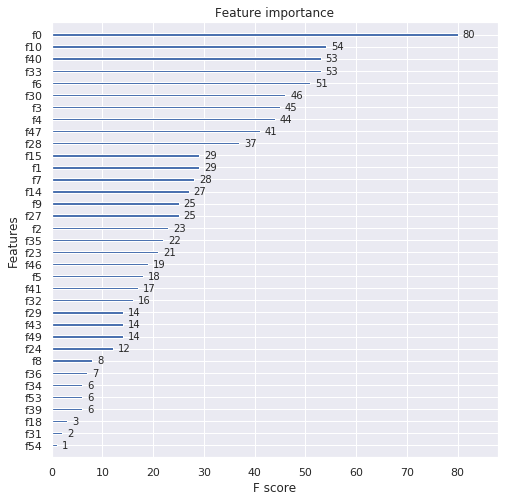

In [203]:
import xgboost as xgb
xgb.plot_importance(classifier);

0.8873083173494696

In [107]:
parameter_df.sort_values(by="mean_auc", ascending=False)

,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,scale_pos_weight,mean_auc
337,0.29,1201,4,3,0.20,1.0,0.9,0.893462
288,0.17,101,14,5,0.18,0.8,1.0,0.892031
106,0.27,501,20,2,0.19,1.0,0.3,0.891086
10,0.11,501,3,1,0.29,1.0,0.9,0.891011
291,0.23,701,13,4,0.19,1.0,0.6,0.889571
...,...,...,...,...,...,...,...,...
995,0.11,601,18,9,0.17,0.5,0.9,NaN
996,0.10,101,12,8,0.21,0.4,0.9,NaN
997,0.12,1401,13,9,0.22,0.2,0.6,NaN
998,0.13,1501,10,9,0.15,1.0,0.4,NaN


In [207]:
classifier = XGBClassifier(
                        learning_rate =0.05, # 0.2
                        n_estimators=139, # 239
                        max_depth=5, #5
                        min_child_weight=5, #5
                        gamma=0.1, # 0.1
                        subsample=0.7, # 0.7
                        colsample_bytree=0.9 , # 0.9
                        objective= 'binary:logistic',
                        nthread=4,
                        scale_pos_weight=0.5, # 0.5
                        seed=27
                        )

# classifier = XGBClassifier(
#                         learning_rate =0.17	, # 0.05
#                         n_estimators=101, # 139
#                         max_depth=14, #5
#                         min_child_weight=5, #5
#                         gamma=0.18, # 0.1
#                         subsample=0.8, # 0.7
#                         colsample_bytree=0.9 , # 0.9
#                         objective= 'binary:logistic',
#                         nthread=4,
#                         scale_pos_weight=1.0, # 0.5
#                         seed=27
#                         )

classifier.fit(dataset_ml_train, dataset_ml_train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=139, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5, seed=27,
              silent=None, subsample=0.7, verbosity=1)

In [208]:
submit_df = pd.DataFrame(dataset[dataset.PassengerId > 891]['PassengerId']).reset_index(drop=True)
submit_df['Survived'] = classifier.predict(dataset_ml_test)
submit_df['Survived'] = submit_df['Survived'].astype(int)
submit_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submit_df.to_csv("submission.csv", index=None)

In [0]:
# files.download("submission.csv")

In [210]:
!kaggle competitions submit -c titanic -f submission.csv -m "Message"

100% 2.77k/2.77k [00:00<00:00, 10.7kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster

# Reference
+ KaggleのWinner solutionにもなった「K近傍を用いた特徴量抽出」のPython実装  
https://upura.hatenablog.com/entry/2018/06/23/165855

+ RとPythonでKruskal-Wallis検定  
https://qiita.com/s-wakaba/items/ffb1a3e65493f277ca49

+ Plotting with categorical data  
https://seaborn.pydata.org/tutorial/categorical.html

+ Python: Target Encoding のやり方について  
https://blog.amedama.jp/entry/target-mean-encoding-types

+ kaggleのtitanicで0.81340を出した話  
http://kefism.hatenablog.com/entry/2017/04/22/203740

+ Python pandas 欠損値/外れ値/離散化の処理  
http://sinhrks.hatenablog.com/entry/2016/02/01/080859